In [31]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy import stats

## 1-Data Exploration

In [32]:
# Đọc dữ liệu từ tệp CSV
df = pd.read_csv("train.csv")
# Hiển thị 5 hàng đầu tiên của DataFrame
df.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [33]:
# Cung cấp thông tin tóm tắt về DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [34]:
# Kiểm tra giá trị bị thiếu
Missing_values = df.isnull().sum()
# Hiển thị kết quả
Missing_values

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [35]:
# thực hiện chuyển đổi cột 'Order Date' của DataFrame df từ dạng chuỗi thành dạng datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

In [36]:
# In ra thông tin về ngày đặt hàng đầu tiên và ngày đặt hàng cuối cùng trong DataFrame df
print(f"First order recorded in: {df['Order Date'].min()}")
print(f"Last order recorded in: {df['Order Date'].max()}")

First order recorded in: 2015-01-03 00:00:00
Last order recorded in: 2018-12-30 00:00:00


## 2-Data Cleaning

In [37]:
# tạo một DataFrame mới có tên là df_filtered, chứa một bản sao của các cột 'Order ID', 'Order Date', 'Sales', 'Customer ID' từ DataFrame gốc df
df_filtered = df[['Order ID',  'Order Date', 'Sales', 'Customer ID']].copy()

In [38]:
df_filtered.isnull().sum()

Order ID       0
Order Date     0
Sales          0
Customer ID    0
dtype: int64

In [39]:
df_filtered.dtypes

Order ID               object
Order Date     datetime64[ns]
Sales                 float64
Customer ID            object
dtype: object

## 3-Feature Engineering

Recency: Khoảng cách ngày mua hàng gần đây nhất 
Frequency: Tần suất mua hàng
Monetary: Tổng số tiền mà khách hàng đã mua hàng

In [40]:
date_snapshot =  df_filtered['Order Date'].max() + pd.Timedelta(days=1)

customers = df_filtered.groupby('Customer ID').agg({'Order Date':lambda x: (date_snapshot - x.max()).days,
                                                   'Order ID':'nunique',
                                                   'Sales':'sum'}).rename(columns={'Order Date':'Recency',
                                                                                         'Order ID': 'Frequency',
                                                                                         'Sales': 'Monetary'})

In [41]:
print(customers.head())
print('=============================================')
print(customers.describe())

             Recency  Frequency  Monetary
Customer ID                              
AA-10315         185          5  5563.560
AA-10375          20          9  1056.390
AA-10480         260          4  1790.512
AA-10645          56          6  5086.935
AB-10015         416          3   886.156
           Recency   Frequency      Monetary
count   793.000000  793.000000    793.000000
mean    149.286255    6.206810   2851.874884
std     187.081466    2.525647   2620.668723
min       1.000000    1.000000      4.833000
25%      31.000000    4.000000   1081.466000
50%      76.000000    6.000000   2215.002000
75%     185.000000    8.000000   3670.258000
max    1166.000000   17.000000  25043.050000


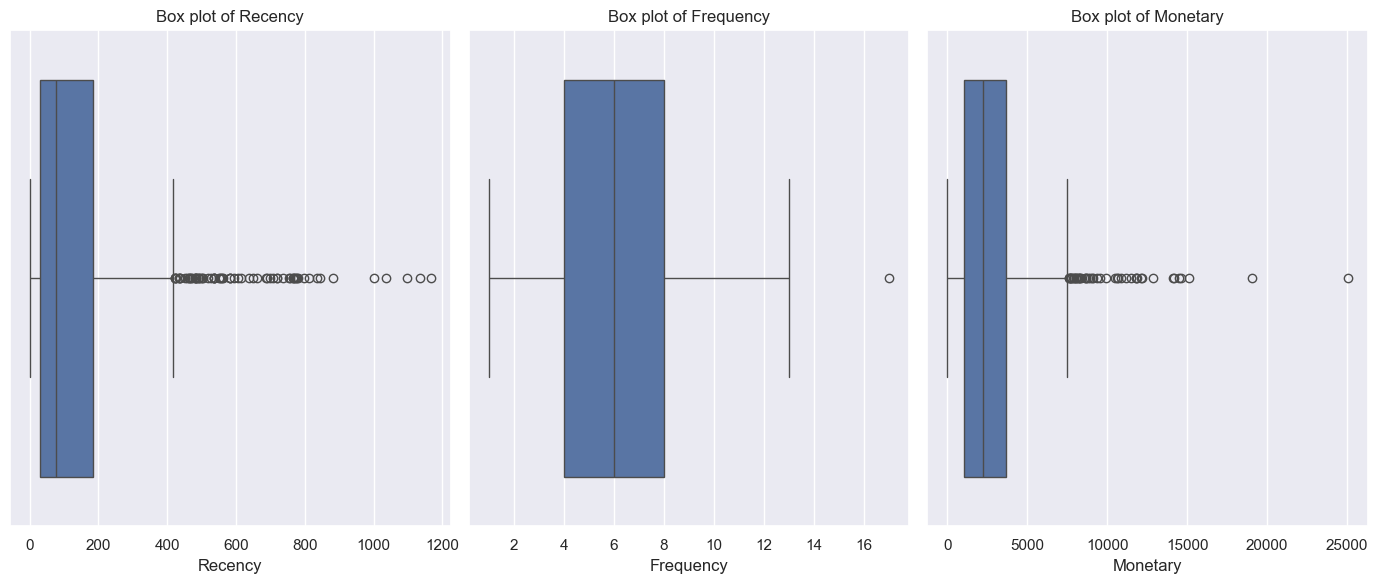

In [42]:
# Kiểm tra ngoại lai
fig, axes = plt.subplots(1,3, figsize=(14,6))

# Vẽ biểu đồ hộp (box plot) để kiểm tra ngoại lai
sns.boxplot(x=customers['Recency'], ax=axes[0])
axes[0].set_title('Box plot of Recency')

sns.boxplot(x=customers['Frequency'], ax=axes[1])
axes[1].set_title('Box plot of Frequency')

sns.boxplot(x=customers['Monetary'], ax=axes[2])
axes[2].set_title('Box plot of Monetary')

plt.tight_layout()
plt.show()

In [43]:
# Xử lý ngoại lai
Q1 = customers['Recency'].quantile(0.05)
Q3 = customers['Recency'].quantile(0.95)
IQR = Q3 - Q1
recency_outliers = customers[(customers['Recency'] < Q1 - 1.5*IQR) | (customers['Recency'] > Q3 + 1.5*IQR)].index
print(f"Số lượng giá trị ngoại lai trong cột Recency: {len(recency_outliers)}")

Q1 = customers['Frequency'].quantile(0.05)
Q3 = customers['Frequency'].quantile(0.95)
IQR = Q3 - Q1
frequency_outliers = customers[(customers['Frequency'] < Q1 - 1.5*IQR) | (customers['Frequency'] > Q3 + 1.5*IQR)].index
print(f"Số lượng giá trị ngoại lai trong cột Frequency: {len(frequency_outliers)}")

Q1 = customers['Monetary'].quantile(0.05)
Q3 = customers['Monetary'].quantile(0.95)
IQR = Q3 - Q1
monetary_outliers = customers[(customers['Monetary'] < Q1 - 1.5*IQR) | (customers['Monetary'] > Q3 + 1.5*IQR)].index
print(f"Số lượng giá trị ngoại lai trong cột Monetary: {len(monetary_outliers)}")
# Xóa các giá trị ngoại lai từ DataFrame
customers = customers.drop(recency_outliers.union(frequency_outliers).union(monetary_outliers))

# In ra số lượng hàng sau khi loại bỏ giá trị ngoại lai
print("Số lượng hàng sau khi loại bỏ giá trị ngoại lai:", len(customers))

Số lượng giá trị ngoại lai trong cột Recency: 0
Số lượng giá trị ngoại lai trong cột Frequency: 0
Số lượng giá trị ngoại lai trong cột Monetary: 1
Số lượng hàng sau khi loại bỏ giá trị ngoại lai: 792


## 4-Kmeans Clustering

Text(0, 0.5, 'SSE')

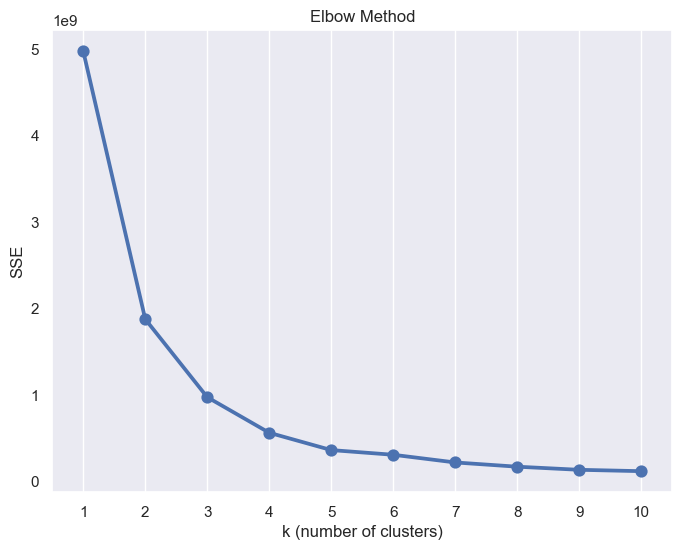

In [44]:
# thực hiện phương pháp "Elbow Method" để xác định số lượng cụm tối ưu cho dữ liệu đã được biến đổi (customers_transformed_df) bằng cách sử dụng thuật toán KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(customers)
    sse[k] = kmeans.inertia_ # tổng bình phương khoảng cách tới trọng tâm cụm gần nhất

# Plot results
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

plt.grid(axis='both')
plt.title('Elbow Method')
plt.xlabel('k (number of clusters)'); plt.ylabel('SSE')

In [45]:
# Loại bỏ cột customerid
customers = customers[['Recency','Frequency','Monetary']]

In [46]:
# Chuẩn hóa dữ liệu
col_names = ['Recency','Frequency','Frequency']
features = customers[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

In [47]:
# Khởi tạo và huấn luyện mô hình KMeans với 3 cụm
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_features)

KMeans(n_clusters=3, random_state=42)

In [48]:
# Dự đoán nhãn cụm
pred = kmeans.predict(scaled_features)
# Tạo DataFrame từ DataFrame gốc và thêm cột nhãn cụm
customers_kmean = pd.DataFrame(customers)
customers_kmean['cluster'] = pred
# Hiển thị 5 dòng đầu tiên của DataFrame đã cập nhật
customers_kmean.head(5)

,Recency,Frequency,Monetary,cluster
Customer ID,,,,
AA-10315,185,5,5563.560,0
AA-10375,20,9,1056.390,1
AA-10480,260,4,1790.512,0
AA-10645,56,6,5086.935,0
AB-10015,416,3,886.156,2


In [49]:
# Tính giá trị trung bình ('mean') của cột 'Recency' và 'Frequency', và tính giá trị trung bình cũng như số lượng ('count') của cột 'Monetary'.
customers_kmean.groupby('cluster').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'Monetary':['mean','count']}).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
cluster                                 
0          99.0       5.0   2175.0   352
1          78.0       9.0   3846.0   336
2         548.0       4.0   1716.0   104

### Dựa vào các thuộc tính của từng cụm, có thể gán nhãn cho các cụm như sau:
- Cụm 1: Loyal
        Đặc điểm: Những khách hàng này không chỉ mua sắm thường xuyên mà còn chi tiêu nhiều và thường quay lại mua hàng trong khoảng thời gian gần đây. 
- Cụm 0: Casual
        Đặc điểm: Những khách hàng này mua hàng không quá thường xuyên và không chi tiêu nhiều như khách hàng trung thành.
- Cụm 2: At Risk
        Đặc điểm: Những khách hàng này đã không mua hàng trong một thời gian dài, ít khi mua hàng và chi tiêu ít.

In [50]:
#Sự phân biệt các phân khúc rất rõ ràng. Do đó, chúng ta có thể gắn nhãn cho từng phân đoạn để rõ ràng hơn.
cluster_mapping = {0:'Casual',
                   1:'Loyal',
                   2:'At-Risk'}

customers_kmean['cluster'] = customers_kmean['cluster'].map(cluster_mapping)
customers_kmean.head()

,Recency,Frequency,Monetary,cluster
Customer ID,,,,
AA-10315,185,5,5563.560,Casual
AA-10375,20,9,1056.390,Loyal
AA-10480,260,4,1790.512,Casual
AA-10645,56,6,5086.935,Casual
AB-10015,416,3,886.156,At-Risk


cluster
Casual     352
Loyal      336
At-Risk    104
Name: count, dtype: int64


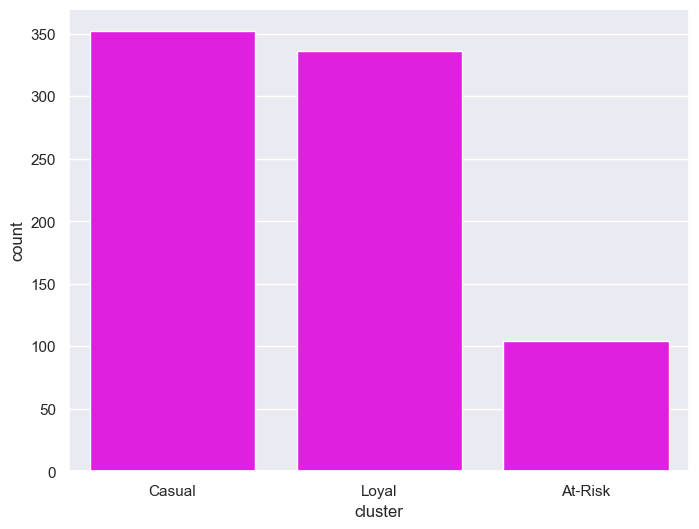

In [51]:
# Đếm số lượng mẫu dữ liệu trong mỗi cụm
print(customers_kmean['cluster'].value_counts())
# Vẽ biểu đồ thanh hiển thị số lượng mẫu dữ liệu trong mỗi cụm
sns.countplot(x=customers_kmean.cluster, color='magenta')
sns.set(rc={"figure.figsize":(8, 6)})
plt.show()

In [52]:
# Chuyển đổi các thuộc tính bị lệch bằng phương pháp box-cox (vì dữ liệu chỉ là dương nên thay vào đó, box-cox được sử dụng để thiết kế của nó chỉ xử lý các giá trị dương)
pt = PowerTransformer(method='box-cox')
# Áp dụng biến đổi đó lên dữ liệu để tạo ra customers_transformed
customers_transformed = pt.fit_transform(customers)
# => Kết quả là customers_transformed sẽ có phân phối gần với phân phối chuẩn hơn so với customers.
# Tạo một DataFrame mới từ dữ liệu đã được biến đổi (customers_transformed) và sử dụng các chỉ mục và cột từ DataFrame gốc (customers)
customers_transformed_df = pd.DataFrame(customers_transformed, index=customers.index, columns=customers.columns)

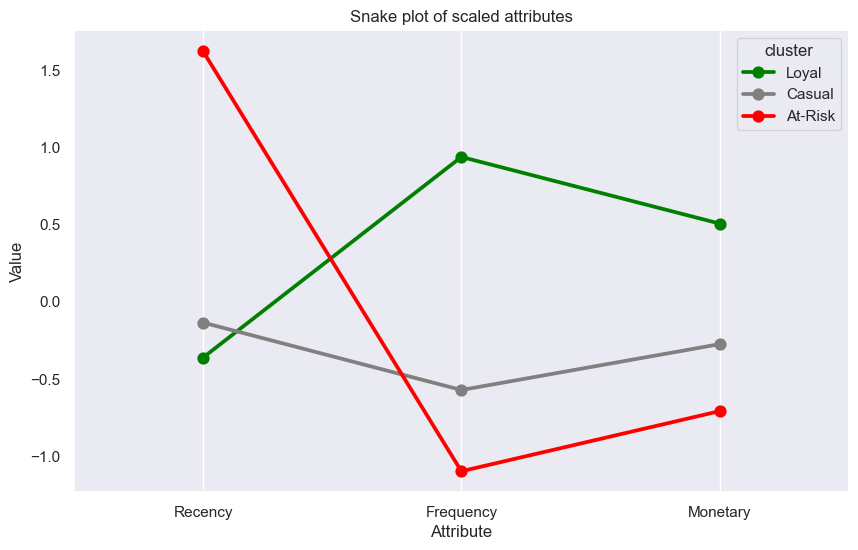

In [53]:


# Thêm cột Cluster vào dataframe đã biến đổi
customers_transformed_df['cluster'] = customers_kmean['cluster']
customers_transformed_df.head()


# Chuyển đổi dữ liệu sang dạng dài (long format)
customers_melt = pd.melt(customers_transformed_df.reset_index(),
                         id_vars=['Customer ID', 'cluster'],
                         value_vars=['Recency', 'Frequency', 'Monetary'],
                         var_name='Attribute',
                         value_name='Value')

# Tạo biểu đồ
figure = plt.figure(figsize=(10, 6))

palette = {'Loyal': 'green', 'Casual': 'grey', 'At-Risk': 'red'}

sns.pointplot(x='Attribute', y='Value', hue='cluster', data=customers_melt, errorbar=None, hue_order=['Loyal', 'Casual', 'At-Risk'], palette=palette)

plt.grid(axis='both')
plt.title('Snake plot of scaled attributes')
plt.show()

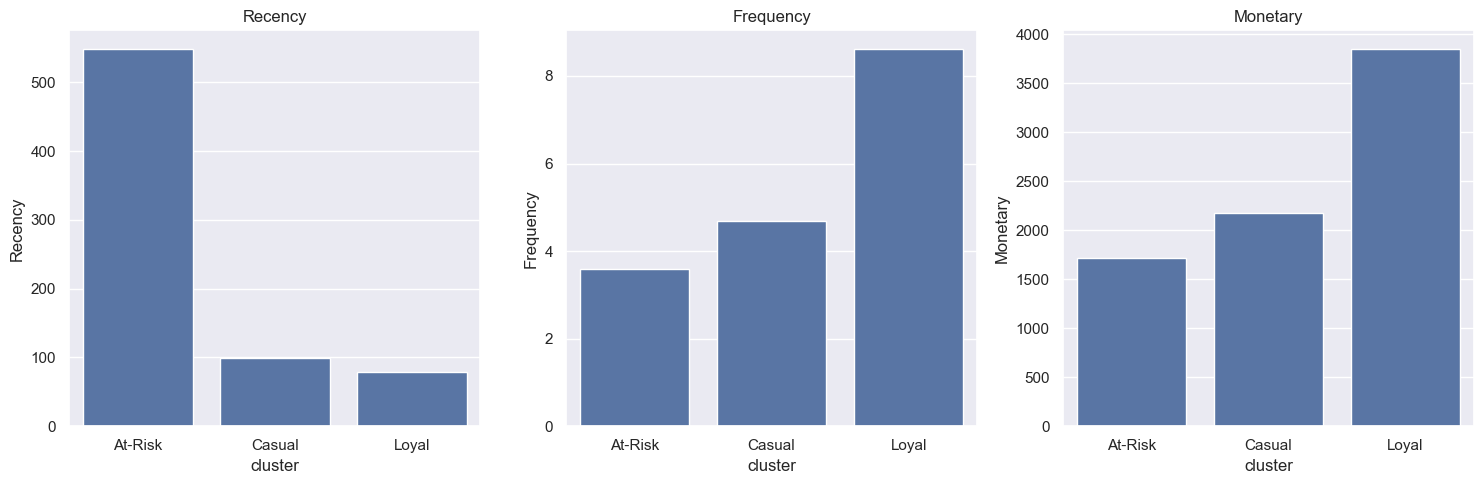

In [54]:
# biểu đồ thanh (bar plots) để so sánh giá trị trung bình của các biến 'Recency', 'Frequency', và 'Monetary' giữa các cụm
avg_df_kmean = customers_kmean.groupby(['cluster'], as_index=False).mean()
list_kmean = ['Recency','Frequency','Monetary']
# Tạo subplot với 1 hàng và 3 cột
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Lặp qua các biến trong list1 để vẽ từng biểu đồ
for i, variable in enumerate(list_kmean):
    sns.barplot(x='cluster', y=variable, data=avg_df_kmean, ax=axes[i])
    axes[i].set_title(variable)  # Đặt tiêu đề cho từng biểu đồ

plt.tight_layout()  # Tăng khoảng cách giữa các biểu đồ
plt.show()

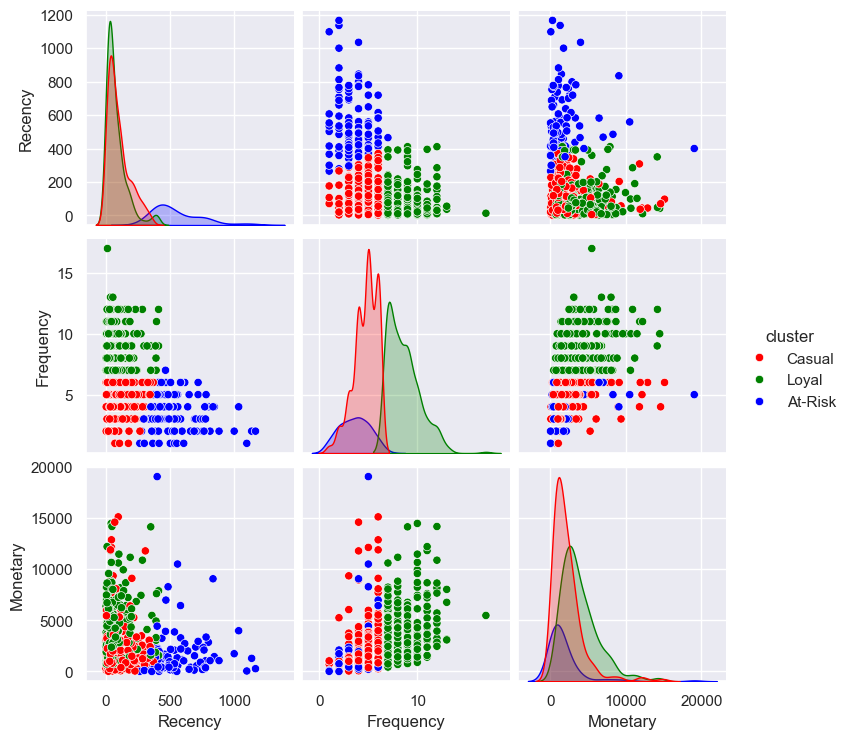

In [55]:
# biểu đồ pairplot được sử dụng để hiển thị mối quan hệ giữa các cặp biến trong dữ liệu. 
# pairplot này sẽ hiển thị các scatter plot của các cặp biến, và mỗi scatter plot sẽ sử dụng màu sắc khác nhau để phân biệt các điểm dữ liệu thuộc vào từng cụm (cluster) khác nhau.
cluster_colors = ['red', 'green', 'blue']
sns.pairplot(customers_kmean, hue="cluster", palette=cluster_colors)

In [56]:
# Sao chép frame sang newdf và gán nhãn cho các cụm
customers_kmean_new = customers_kmean
customers_kmean_new["label"] = customers_kmean["cluster"]

In [57]:
import plotly.graph_objects as go

fig = go.Figure()

# Vẽ các điểm dữ liệu theo từng nhãn
fig.add_trace(go.Scatter3d(
    x=customers_kmean_new.Recency[customers_kmean_new.label == 'Loyal'],
    y=customers_kmean_new["Frequency"][customers_kmean_new.label == 'Loyal'],
    z=customers_kmean_new["Monetary"][customers_kmean_new.label == 'Loyal'],
    mode='markers',
    marker=dict(color='green', size=5),
    name='Loyal'
))

fig.add_trace(go.Scatter3d(
    x=customers_kmean_new.Recency[customers_kmean_new.label == 'Casual'],
    y=customers_kmean_new["Frequency"][customers_kmean_new.label == 'Casual'],
    z=customers_kmean_new["Monetary"][customers_kmean_new.label == 'Casual'],
    mode='markers',
    marker=dict(color='grey', size=5),
    name='Casual'
))

fig.add_trace(go.Scatter3d(
    x=customers_kmean_new.Recency[customers_kmean_new.label == 'At-Risk'],
    y=customers_kmean_new["Frequency"][customers_kmean_new.label == 'At-Risk'],
    z=customers_kmean_new["Monetary"][customers_kmean_new.label == 'At-Risk'],
    mode='markers',
    marker=dict(color='red', size=5),
    name='At-Risk'
))

fig.update_layout(scene=dict(
                    xaxis_title='Recency',
                    yaxis_title='Frequency',
                    zaxis_title='Monetary'
                ))

fig.show()

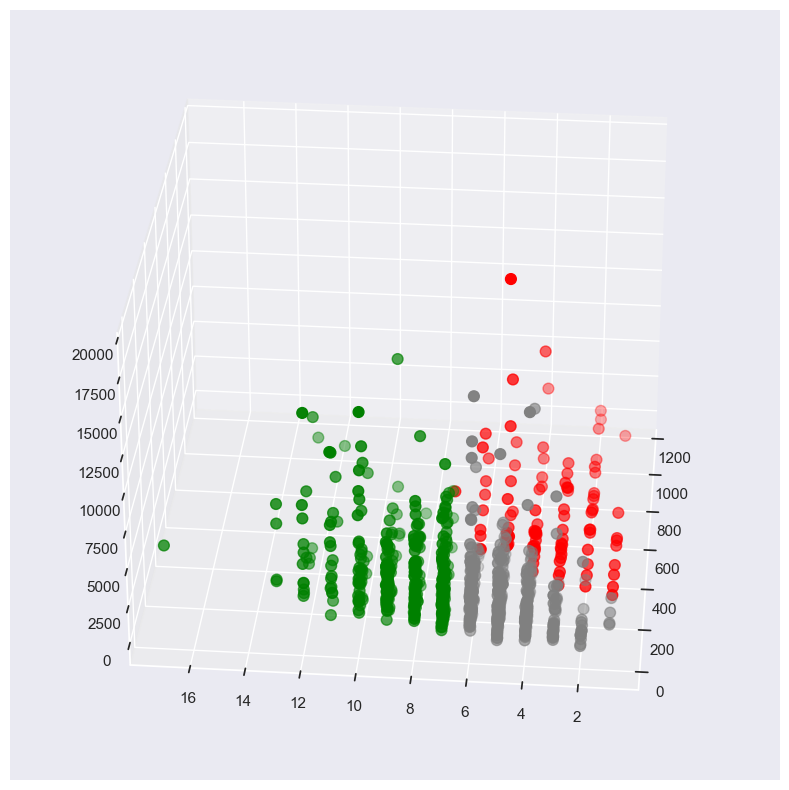

In [58]:
# Tạo biểu đồ phân tán 3D
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
# Vẽ các điểm dữ liệu theo từng nhãn
ax.scatter(customers_kmean_new.Recency[customers_kmean_new.label == 'Loyal'], customers_kmean_new["Frequency"][customers_kmean_new.label == 'Loyal'], customers_kmean_new["Monetary"][customers_kmean_new.label == 'Loyal'], c='green', s=60)
ax.scatter(customers_kmean_new.Recency[customers_kmean_new.label == 'Casual'], customers_kmean_new["Frequency"][customers_kmean_new.label == 'Casual'], customers_kmean_new["Monetary"][customers_kmean_new.label == 'Casual'], c='grey', s=60)
ax.scatter(customers_kmean_new.Recency[customers_kmean_new.label == 'At-Risk'], customers_kmean_new["Frequency"][customers_kmean_new.label == 'At-Risk'], customers_kmean_new["Monetary"][customers_kmean_new.label == 'At-Risk'], c='red', s=60)
# Thiết lập góc nhìn
ax.view_init(30, 185)
plt.show()

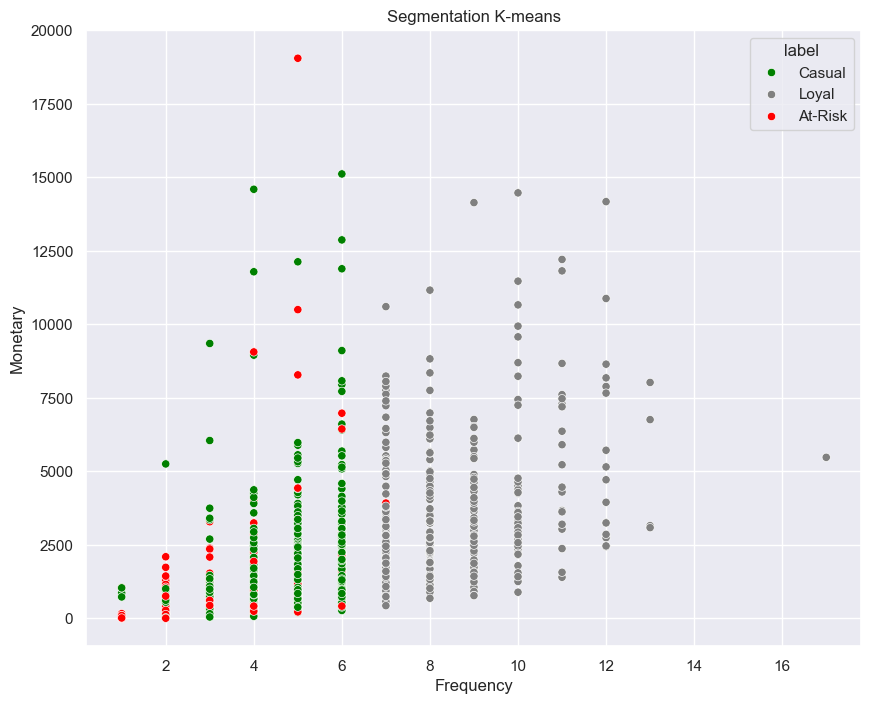

In [59]:
# biểu đồ phân tán 2D để hiển thị các điểm dữ liệu theo tần suất mua hàng (Frequency) và giá trị mua hàng (Monetary), phân biệt theo các nhãn cụm khác nhau
# Thiết lập các trục x và y
x_axis = customers_kmean_new['Frequency']
y_axis = customers_kmean_new['Monetary']
# Tạo biểu đồ phân tán 2D
plt.figure(figsize = (10, 8))
sns.scatterplot(x='Frequency', y='Monetary', hue='label', data=customers_kmean_new, palette=['green', 'grey', 'red'])
plt.title('Segmentation K-means')
plt.show()

The average silhouette_score is : 0.4685787365663896


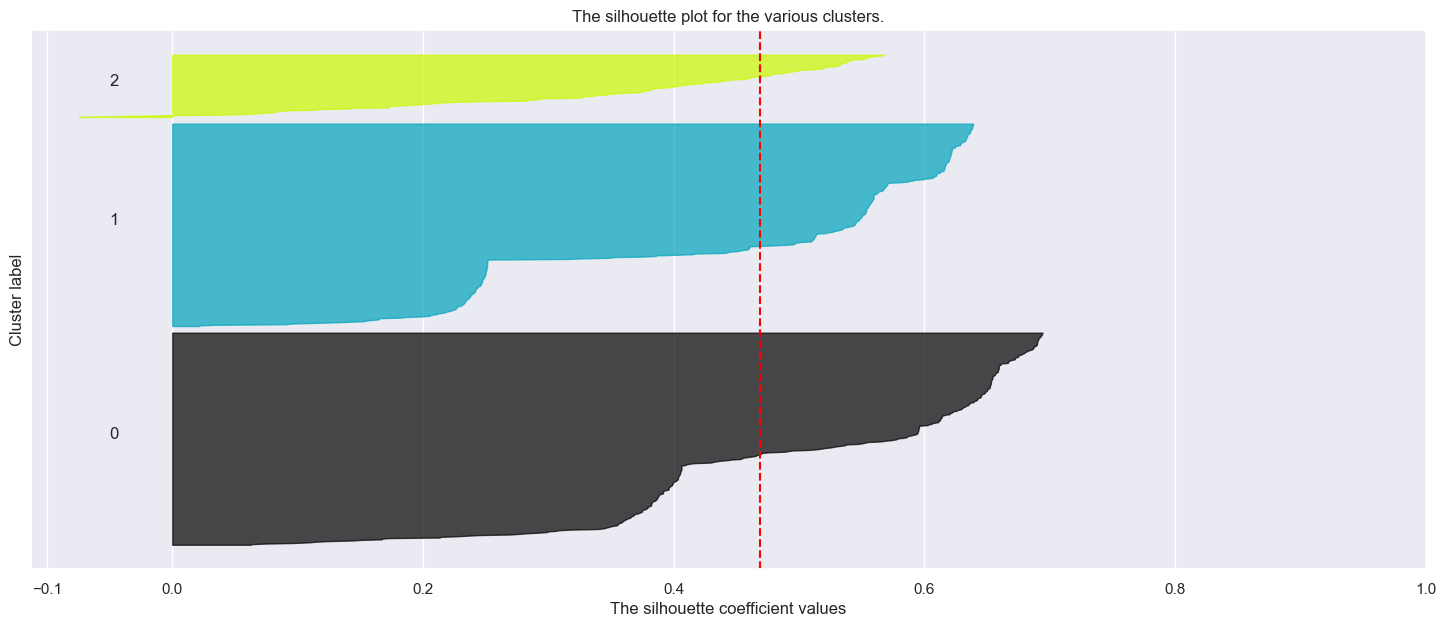

In [60]:
# Biểu đồ silhouette để trực quan hóa chất lượng của việc phân cụm dữ liệu, giúp hiểu được các cụm được hình thành tốt đến đâu
n_clusters = 3

# Tính toán điểm silhouette trung bình cho toàn bộ tập dữ liệu
silhouette_avg = silhouette_score(scaled_features, pred)
print(f"The average silhouette_score is : {silhouette_avg}")

# Tính toán điểm silhouette cho mỗi mẫu
sample_silhouette_values = silhouette_samples(scaled_features, pred)

# Tạo một subplot với kích thước đã được chỉ định
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# Biến này được sử dụng để định vị các biểu đồ silhouette theo chiều dọc
y_lower = 10
# Lặp qua mỗi cụm để vẽ các điểm silhouette
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[pred == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Dán nhãn cho các silhouette plots bằng số cụm của chúng ở giữa
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Tính y_low mới cho đồ thị tiếp theo
    y_lower = y_upper + 10  # 10 for the 0 samples

# Đặt tiêu đề và nhãn cho biểu đồ
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# Vẽ một đường thẳng đứng cho điểm silhouette trung bình
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

# Tùy chỉnh các dấu chấm trên trục y và x
ax1.set_yticks([])   # Xóa các nhãn / dấu chấm trên trục y
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

Điểm silhouette trung bình ở gần 0.47 cho thấy cụm tương đối tốt, với sự phân chia rõ ràng giữa các cụm, nhưng có một số mẫu có thể nằm gần biên cụm. Điều này cũng có thể chỉ ra rằng có thể có cơ hội cải thiện hiệu suất phân cụm bằng cách tối ưu hóa số lượng cụm hoặc các phương pháp phân cụm khác.

### Kết luận : Dựa vào các đặc điểm của từng loại khách hàng để có những chiến lược sau:
1. Khách hàng trung thành (Loyal Customers)
- Mục tiêu: Duy trì và tăng cường sự trung thành của khách hàng, thúc đẩy họ tiếp tục mua sắm và trở thành đại sứ thương hiệu.
- Chiến lược:
Chương trình khách hàng thân thiết: Cung cấp các ưu đãi đặc biệt, điểm thưởng, hoặc quà tặng để khuyến khích mua hàng tiếp theo.
Ưu đãi độc quyền: Cung cấp quyền truy cập sớm vào các sản phẩm mới, giảm giá đặc biệt hoặc các sự kiện dành riêng cho khách hàng trung thành.
Chăm sóc cá nhân hóa: Gửi email chúc mừng sinh nhật, kỷ niệm mua hàng và cung cấp các ưu đãi cá nhân hóa dựa trên sở thích và lịch sử mua sắm của họ.
2. Khách hàng thường xuyên (Casual Customers)
- Mục tiêu: Chuyển đổi khách hàng thường xuyên thành khách hàng trung thành bằng cách tăng cường tần suất mua hàng và sự gắn kết với thương hiệu.
- Chiến lược:
Khuyến mãi và giảm giá: Cung cấp các chương trình giảm giá, ưu đãi hoặc phiếu mua hàng để thúc đẩy họ mua sắm thường xuyên hơn.
Email marketing: Gửi email nhắc nhở về các chương trình khuyến mãi, sản phẩm mới hoặc các sự kiện đặc biệt.
Chương trình khuyến khích: Tạo ra các chương trình khuyến khích như "Mua X lần, nhận 1 lần miễn phí" để tăng tần suất mua hàng.
Chương trình giới thiệu sản phẩm mới: Cung cấp cho họ thông tin về các sản phẩm mới và mời họ thử nghiệm với giá ưu đãi hoặc khuyến mãi đặc biệt.
3. Khách hàng có nguy cơ (At Risk Customers)
- Mục tiêu: Thu hút lại sự quan tâm của khách hàng, và khuyến khích họ quay lại mua sắm.
- Chiến lược:
Chương trình tái kích hoạt: Gửi email tái kích hoạt với các ưu đãi đặc biệt, mã giảm giá hoặc lời mời quay lại mua sắm.
Khảo sát và phân tích: Gửi khảo sát để hiểu lý do tại sao họ đã ngừng mua sắm và cải thiện các khía cạnh yếu kém dựa trên phản hồi của họ.
Chăm sóc đặc biệt: Liên hệ trực tiếp qua điện thoại hoặc email để thăm hỏi và cung cấp các ưu đãi đặc biệt nhằm khuyến khích họ quay lại.
Chương trình giảm giá thời hạn ngắn: Tạo ra các chương trình giảm giá ngắn hạn hoặc khuyến mãi đặc biệt để khuyến khích mua hàng ngay lập tức.
Cải thiện dịch vụ hậu mãi: Đảm bảo rằng dịch vụ hậu mãi, hỗ trợ khách hàng và chăm sóc sau bán hàng được cải thiện để tăng cường sự hài lòng và tin tưởng.